In [1]:
# NVIDIA Quadro T1000
# tensorflow 2.0
# cuda 10.0
# cudnn for cuda 10.0

In [2]:
# 파일경로 설정
import os
import shutil
import json

# Modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

# resnet50
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
# GPU 환경 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.test.is_gpu_available()

True

In [5]:
tf.test.gpu_device_name()
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Others
import pandas as pd
from glob import glob
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
data_path = './new_open'

train_path = data_path + '/train'
test_path = data_path + '/test'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

In [8]:
train_path

'./new_open/train'

In [9]:
hand_gesture

,pose_id,pose_type,pose_name,gesture_type,hand_type,view_type
0,0,number,숫자 1,my_hand,left,1st
1,1,number,숫자 2,my_hand,left,1st
2,2,number,숫자 3,my_hand,left,1st
3,3,number,숫자 4,my_hand,left,1st
4,4,number,숫자 5,my_hand,left,1st
...,...,...,...,...,...,...
152,191,meaning,경고(주먹 내밀기),your_hand,both,3rd
153,192,meaning,X,your_hand,both,3rd
154,193,meaning,OK,your_hand,both,3rd
155,194,meaning,빅토리,your_hand,both,3rd


In [10]:
# Train 데이터에 있는 폴더를 glob로 불러와
# sorted method를 통해 숫자 순으로 정렬합니다.
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('\\')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('\\')[-1]))
train_folders[:5]

['./new_open/train\\0',
 './new_open/train\\1',
 './new_open/train\\2',
 './new_open/train\\3',
 './new_open/train\\4']

(1080, 1920, 3)


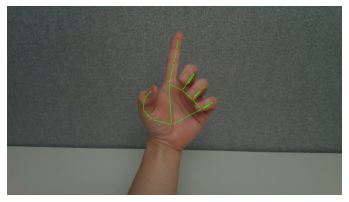

In [11]:
from PIL import Image
train_folder = train_folders[0]

image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('\\')[-1].replace('.png','')))
json_path   = glob(train_folder + '/*.json')[0]

image_path = image_paths[0]
img = Image.open(image_path)
img_arr = np.array(img)
print(img_arr.shape)
plt.imshow(img_arr)
plt.axis('off')
plt.show()

js = json.load(open(json_path))

In [12]:
print("json keys              : ", js.keys())
print("json action info       : ",js.get('action'))
print("json actor info        : ",js.get('actor'))
print("json annotations keys  : ",js.get('annotations')[0].keys())


json keys              :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info       :  [0, '숫자 1']
json actor info        :  None
json annotations keys  :  dict_keys(['image_id', 'data'])


In [13]:
print(js.get('annotations')[1].get('data'))

[[942.1134567260742, 710.6305289268494, 0.012014260282739997], [836.941967010498, 674.405837059021, -157.17395782470703], [783.669376373291, 603.8488268852234, -255.00306129455566], [789.5053482055664, 534.0386724472046, -334.1238784790039], [841.6403388977051, 495.79675555229187, -393.7507724761963], [929.5931625366211, 448.58365416526794, -141.1239767074585], [950.9478950500488, 330.9519124031067, -213.24504375457764], [966.9838714599609, 251.38158559799194, -283.91075134277344], [974.9141693115234, 188.10632228851318, -342.67653465270996], [1003.6468505859375, 483.2635545730591, -130.5311107635498], [1067.5098037719727, 380.28340101242065, -278.64489555358887], [1050.6416702270508, 418.00708293914795, -393.84312629699707], [1018.5904312133789, 468.7562906742096, -450.7006645202637], [1064.8730850219727, 535.556298494339, -136.29863262176514], [1135.4169845581055, 450.96655011177063, -284.9048137664795], [1097.870750427246, 490.15764713287354, -398.0376720428467], [1046.3242721557617

In [14]:
answers = []
for train_folder in train_folders :
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1]
    answers.append([train_folder.replace(data_path,''),cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])

classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()


In [15]:
np.random.shuffle(train_folders) # 일반화 가능성 높이기

images  = []
targets = []

for train_folder in tqdm(train_folders) :
    image_paths = sorted(glob(train_folder + '/*.png'), key = lambda x : int(x.split('\\')[-1].replace('.png','')))
    query_path  = train_folder.replace(data_path,'')
    target = classes[int(train_folder.split('\\')[-1])]
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        images.append(img)
        targets.append(target)

X = np.array(images)
print('Train X Shape : ', X.shape)

y = np.array(targets)
print('Train y Shape : ', y.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      random_state=2021,
                                                      test_size=0.2,
                                                      stratify = y)

print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)
print('y_train shape : ', y_train.shape)
print('y_valid shape : ', y_valid.shape)


100%|████████████████████████████████████████████████████████████████████████████████| 649/649 [03:44<00:00,  2.89it/s]


Train X Shape :  (5888, 224, 224, 3)
Train y Shape :  (5888, 157)
X_train shape :  (4710, 224, 224, 3)
X_valid shape :  (1178, 224, 224, 3)
y_train shape :  (4710, 157)
y_valid shape :  (1178, 157)


In [16]:
test_images  = []
for test_folder in tqdm(test_folders, total = len(test_folders)) :
    image_paths = sorted(glob(test_folder + '/*.png'), key = lambda x : int(x.split('\\')[-1].replace('.png','')))
    query_path  = test_folder.replace(data_path,'')
    test_image = []
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        test_image.append(img)
    test_images.append(test_image)

test_images = np.array(test_images)
print(test_images.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [01:19<00:00,  2.72it/s]

(217,)


In [17]:
# number of classes 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
  
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(classes.shape[1], activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data = (X_valid, y_valid),
          epochs=30, 
          verbose = 1,
          batch_size=16)

Train on 4710 samples, validate on 1178 samples
Epoch 1/30
4710/4710 [==============================] - 106s 23ms/sample - loss: 4.8716 - accuracy: 0.0251 - val_loss: 5.1657 - val_accuracy: 0.0059
Epoch 2/30
4710/4710 [==============================] - 93s 20ms/sample - loss: 3.8511 - accuracy: 0.0648 - val_loss: 4.6086 - val_accuracy: 0.0374
Epoch 3/30
4710/4710 [==============================] - 96s 20ms/sample - loss: 3.0499 - accuracy: 0.1609 - val_loss: 3.1976 - val_accuracy: 0.1783
Epoch 4/30
4710/4710 [==============================] - 92s 20ms/sample - loss: 2.2263 - accuracy: 0.3393 - val_loss: 3.1230 - val_accuracy: 0.2334
Epoch 5/30
4710/4710 [==============================] - 87s 18ms/sample - loss: 1.6028 - accuracy: 0.4981 - val_loss: 6.7500 - val_accuracy: 0.1528
Epoch 6/30
4710/4710 [==============================] - 89s 19ms/sample - loss: 1.1217 - accuracy: 0.6461 - val_loss: 1.5860 - val_accuracy: 0.5255
Epoch 7/30
4710/4710 [==============================] - 89s 19m

In [18]:
predictions = []
for test_image in tqdm(test_images, total = len(test_images)) :
    prediction = np.mean(model.predict(np.array(test_image)), axis = 0)
    predictions.append(prediction)

sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('./sample_submission.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:32<00:00,  6.76it/s]


,Image_Path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,...,Label_177,Label_186,Label_188,Label_189,Label_190,Label_191,Label_192,Label_193,Label_194,Label_195
0,./test\649,2.557766e-02,2.083002e-03,5.250789e-11,5.636156e-06,2.191243e-11,6.443333e-07,6.884370e-01,1.757518e-07,1.570493e-12,...,1.537412e-13,1.289603e-15,4.027348e-14,6.625594e-08,1.305792e-09,1.077062e-09,1.729618e-09,7.327704e-14,2.164219e-11,3.618835e-19
1,./test\650,9.737892e-06,2.785325e-09,5.436522e-15,1.792136e-15,2.885904e-17,1.000951e-16,2.742777e-05,1.807386e-07,2.979868e-13,...,9.657188e-13,9.451857e-20,6.286098e-17,1.479292e-13,4.248202e-12,2.344309e-11,2.689498e-13,4.767792e-11,3.554148e-13,3.227538e-21
2,./test\651,3.768452e-09,3.362280e-04,5.061844e-04,2.984386e-10,1.060485e-15,1.811067e-16,7.433520e-12,5.615168e-06,3.724718e-07,...,7.808635e-10,2.010589e-15,2.842684e-12,5.316451e-14,5.416710e-10,2.355930e-13,5.666988e-14,1.253177e-10,3.087040e-06,2.028660e-16
3,./test\652,1.347902e-08,3.471762e-04,9.841999e-06,1.426984e-09,8.273338e-15,1.345899e-16,5.255385e-12,9.004904e-07,6.178217e-08,...,4.090244e-09,7.670944e-14,2.222221e-11,4.607804e-13,1.954807e-08,2.330727e-12,9.450099e-13,2.752545e-10,1.299696e-06,1.594165e-17
4,./test\653,2.091006e-12,4.837935e-10,2.862771e-04,2.109155e-06,4.194808e-08,1.694930e-15,7.159529e-15,6.008333e-12,2.165324e-06,...,5.482397e-11,1.459716e-09,1.404869e-08,6.119230e-14,7.416773e-10,7.371405e-13,8.182494e-10,3.908459e-10,1.631781e-06,2.186276e-13
